# Solar-System-Problem:   Energy conservation

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  
    
<li><a href="#Definition-of-the-N-body-problem"> 
              Definition of the N-body problem</a></li>  

<li><a href="#Initial-value-problem:-Solar-System-Problem">
             Initial value problem: Solar-System-Problem</a></li>

<li><a href="#Energy errors">
             Energy-errors</a></li>
                    

</ul>  

## Loading packages

In [ ]:
using OrdinaryDiffEq
using DiffEqDevTools,BenchmarkTools
using Plots,LinearAlgebra
using Dates,LaTeXStrings
using JLD2, FileIO
using IRKGaussLegendre

<a href="#top">Back to the top</a>

## Computer properties

In [ ]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

In [ ]:
#;cat /proc/cpuinfo # on Linux machines

In [ ]:
using Hwloc
Hwloc.num_physical_cores()

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem



**Equations**


The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:

\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}

This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm).
\end{equation*}


**State variables and parameters**

We implement the state variables as an array with three indices:

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{3\times N \times 2}, 
\end{equation*}

where $u[i,j,k] \in \mathbb{R}$:

- The index $i$ takes the values $y=1,2,3$, referring to the coordinate $x,y,z$ respectively.
- The index $j$ takes the values $j=1,2,\dots,N$, referring to the corresponding planet.
- The index $k$ takes the values $k=1,2$, referring to the position if $k=1$ and the speed if $k=2$.

The vector with the constant parameters of the problem is::

\begin{equation*}
p = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N,
\end{equation*}

where $Gm_i$ corresponds to the mass of the $i$th body multiplied by the universal gravity constant $G$.

### Initial value problem: 9-body model of the Solar System

We consider $N=9$ bodies of solar system: the Sun, Mercury, Venus, Earth-Moon, Mars, Jupiter, Saturn, Uranus, Neptune,  Pluto.
The initial values $u_0$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969).

<a href="#top">Back to the top</a>

## Initial value problem: Solar-System-Problem

In [4]:
setprecision(BigFloat, 108);
include("../ODEProblems/Nbody.jl")
include("../ODEProblems/NbodyDyn.jl")
include("../ODEProblems/Nbody2nd.jl")
include("../ODEProblems/Initial9Body.jl")

dt=6
t0=0.0
t1=10^6


u064,Gm64 =Initial9Body(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=Initial9Body(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128)

q064=u064[:,:,1]
v064=u064[:,:,2]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[:,:,1]
v0128=u0128[:,:,2]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);


(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64, 3}, Vector{Float64}, Tuple{Float64, Int64}, Array{BigFloat, 3}, Vector{BigFloat}, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Energy errors

In [5]:
setprecision(BigFloat, 256)

u0256,Gm256=Initial9Body(BigFloat)

E0=NbodyEnergy(u0256,Gm256)


-9.831943675569246832697725914994269405481280867143327637206836004827340997545267e-12

### Numerical integrations

In [6]:
mstep=100
sol1= solve(prob64,IRKGL16(second_order_ode=true, mstep=mstep),adaptive=false, dt=6)
sol1.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  9891584
Number of function 2 evaluations:                  8558248
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1069781
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          166667
Number of rejected steps:                          0

In [7]:
sol2= solve(prob64,IRKGL16(second_order_ode=true, simd=true, mstep=mstep),adaptive=false, dt=6)
sol2.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  9888280
Number of function 2 evaluations:                  8554944
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1069368
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          166667
Number of rejected steps:                          0

In [8]:
sol11 =solve(probdyn64,Vern9(), abstol=1e-13,reltol=1e-13) 
sol11.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  8168514
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          510532
Number of rejected steps:                          0

In [9]:
sol21= solve(prob2nd64,DPRKN12(),abstol=1e-13,reltol=1e-13) 
sol21.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  3694953
Number of function 2 evaluations:                  217351
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          217350
Number of rejected steps:                          0

In [17]:
k=1000
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol2.u)./E0.-1
ΔE11 = map(x->NbodyEnergy3(BigFloat.(x),Gm256), sol11.u[1:k:end])./E0.-1
ΔE21 = map(x->NbodyEnergy4(BigFloat.(x),Gm256), sol21.u[1:k:end])./E0.-1
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE2))),Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE11))), Float32(maximum(abs.(ΔE21))))

(4.985258f-16, 5.494033f-16, 4.985258f-16, 1.8760215f-12, 8.6865404f-14)

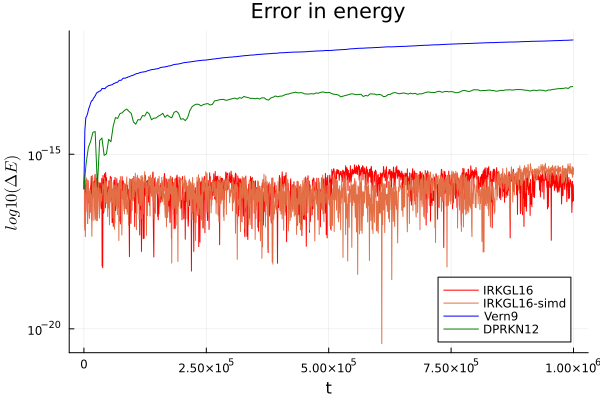

In [23]:
pl1=plot(title="Error in energy", xlabel="t", ylabel=L"log10(\Delta E)", legend=:bottomright)
plot!(pl1, sol1.t[2:end], abs.(ΔE1[2:end]), yscale=:log10, label="IRKGL16", color="red")
plot!(pl1, sol2.t[2:end], abs.(ΔE2[2:end]), yscale=:log10, label="IRKGL16-simd")
plot!(pl1, sol11.t[1:k:end], abs.(ΔE11), yscale=:log10, label="Vern9", color="blue")
plot!(pl1, sol21.t[1:k:end], abs.(ΔE21), yscale=:log10, label="DPRKN12", color="green")

<a href="#top">Back to the top</a>